<a href="https://colab.research.google.com/github/zachfreitas/ADS_504_Machine_Learning/blob/main/Module_2/LAB_DecisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). 



Link to the -> [Book](http://shop.oreilly.com/product/0636920034919.do)


<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.08-Random-Forests.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Decision Trees

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Motivating Random Forests: Decision Trees

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Example)

### Creating a decision tree


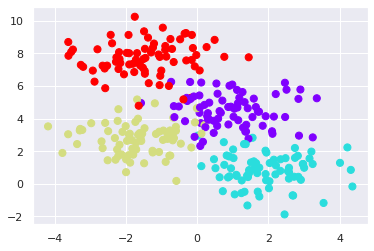

In [5]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Levels)

In [6]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [7]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


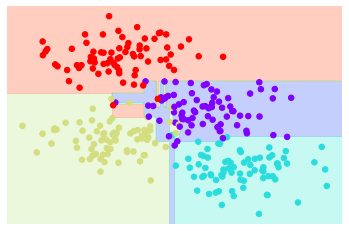

In [8]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [22]:
%%file helpers_05_09.py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0,10000]);

Overwriting helpers_05_09.py


In [23]:
# helpers_05_08 is found in the online appendix
import helpers_05_09

helpers_05_09.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 1000), value=0), Output()), _dom_classe…

### Decision trees and over-fitting
Over-fitting are high Variance and Low Bias. <br>
Under-fitting is low variance and high bias.



![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

## Ensembles of Estimators: Random Forests



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


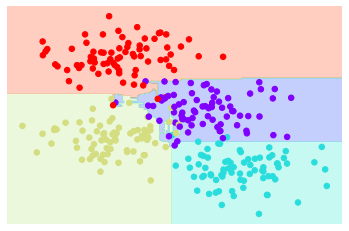

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


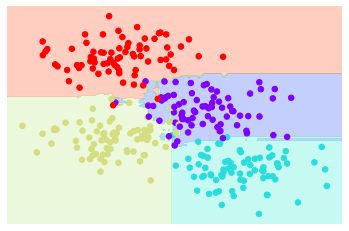

In [30]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);